# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import numpy as np
import pandas as pd

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Set seeds to get reproducible VAE trained models
process.set_all_seeds()

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(os.path.join(base_dir, "configs", "config_test.tsv"))

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]

# Template experiment ID
project_id = params["project_id"]

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params["shared_genes_filename"]

# Output files of recount2 template experiment data
raw_template_filename = params["raw_template_filename"]
mapped_template_filename = params["mapped_template_filename"]

# Output files of recount2 compendium data
raw_compendium_filename = params["raw_compendium_filename"]
mapped_compendium_filename = params["mapped_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params["scaler_filename"]

## Test: Downloading data

In [4]:
# Directory where the downloaded files of template experiment will be saved into
template_download_dir = os.path.join(local_dir, "template_download")

# Make sure this directory already exists
os.makedirs(template_download_dir, exist_ok=True)

In [5]:
%%R -i project_id -i template_download_dir -i raw_template_filename -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/download_recount2_data.R'))

get_recount2_template_experiment(project_id, template_download_dir, raw_template_filename)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, 

Loading objects:
  rse_gene


In [6]:
assert os.path.exists(raw_template_filename)

## Test: Renaming gene ids

In [7]:
# File mapping ensembl ids to hgnc symbols
gene_id_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "ensembl_hgnc_mapping.tsv"
)

In [8]:
%%R -i raw_template_filename -i gene_id_filename -i base_dir

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)
# Input: raw_template_filename, output: gene_id_filename

source(paste0(base_dir, '/generic_expression_patterns_modules/process_names.R'))

# Note: This mapping file from ensembl ids to hgnc symbols is based on the library("biomaRt")
# that gets updated. In order to get the most up-to-date version, you can delete the
# ensembl_hgnc_mapping file to re-run the script that generates this mapping.

if (file.exists(gene_id_filename) == FALSE) {
    get_ensembl_symbol_mapping(raw_template_filename, gene_id_filename)
}

## Test: processing template data
This step will map the ensembl gene IDs in raw template data file to hgnc gene symbols, and delete certain columns (genes) and rows (samples).

Output files generated in this step:
- `shared_genes_filename`: pickled list of shared genes (created only if it doesn't exist yet)
- `mapped_template_filename`: template data with column names mapped to hgnc gene symbols

In [9]:
manual_mapping = {
    "ENSG00000187510.7": "PLEKHG7",
    "ENSG00000230417.11": "LINC00595",
    "ENSG00000276085.1": "CCL3L1",
    "ENSG00000255374.3": "TAS2R45",
}

process.map_recount2_data(
    raw_template_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    shared_genes_filename,
    mapped_template_filename,
)

## Test: Processing compendium

In [10]:
process.process_raw_compendium_recount2(
    raw_compendium_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    shared_genes_filename,
    mapped_compendium_filename,
    normalized_compendium_filename,
    scaler_filename,
)

In [11]:
# Check number of genes is equal between the compendium and the template
compendium_data = pd.read_csv(
    normalized_compendium_filename, sep="\t", index_col=0, header=0
)

template_data = pd.read_csv(mapped_template_filename, header=0, sep="\t", index_col=0)
assert compendium_data.shape[1] == template_data.shape[1]

## Train: VAE training and reproducibility

In [12]:
# Create VAE directories
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]
NN_architecture = params["NN_architecture"]

for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(new_dir, exist_ok=True)

input dataset contains 92 samples and 17788 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 83 samples, validate on 9 samples
Epoch 1/5
83/83 [==============================] - 27s 320ms/step - loss: 9298.6198 - val_loss: 149359.5625
Epoch 2/5
83/83 [==============================] - 26s 314ms/step - loss: 7997.1775 - val_loss: 25085.4284
Epoch 3/5
83/83 [==============================] - 27s 321ms/step - loss: 7876.3152 - val_loss: 15018.1660
Epoch 4/5
83/83 [==============================] - 27s 324ms/step - loss: 7889.4818 - val_loss: 10852.7154
Epoch 5/5
83/83 [==============================] - 27s 323ms/step - loss: 7849.6292 - val_loss: 10629.0273


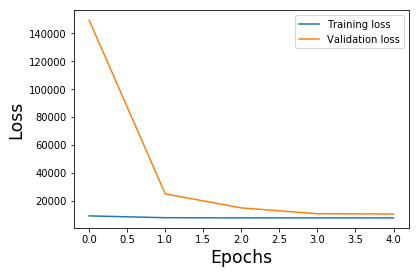

In [13]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)

In [14]:
# Test reproducibility
expected_log = "data/test_vae_logs.tsv"
actual_log = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert pd.read_csv(actual_log, sep="\t")["val_loss"].values[-1] < 15000, pd.read_csv(
    actual_log, sep="\t"
)["val_loss"].values[-1]